In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

## Data Loading and Cleaning

The dataset contains three subsets. As a first step, we load all datasets and create one pandas dataframe to include all the useful features and information for our project. Given our goal is to forecast 

In [2]:
asset_df = pd.read_csv('assets.txt', sep=",")
events_df = pd.read_csv('events.txt', sep=",")
sale_events_df = pd.read_csv('sale_events.txt', sep=",")

# Change the price formation of total_price to remove redundant 0's for each price
adj_price = []
for i in range(len(sale_events_df)):
    adj_price.append(float(sale_events_df.loc[i]['total_price']) / 10e+18)

sale_events_df.total_price = adj_price

C:\Users\oswal\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (0,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


For asset_df, we drop all the rows that are not an token entry. Since we will just use token_id to join different dataframes, we will drop the "id" column. Additionally, we will drop the "image_url", "permalink" and "collection" columns since they do not add information for our model. 

In [3]:
asset_df_clean = asset_df.drop(asset_df[asset_df.token_id == 'token_id'].index, axis=0)
asset_df_clean = asset_df_clean.drop(labels=['id', 'image_url', 'permalink', 'collection'], axis=1)

For sale_events_df, we will create the average sales price for each token_id and use the price as the target to train the model. Since other informations (except created_date) all have the same value, they do not provide additional information for our forecast and thus are dropped. 

In [4]:
token_id = sale_events_df.token_id.unique()
price_df = pd.DataFrame(columns=['token_id', 'ave_price'])

for i in range(len(token_id)):
    current_token = token_id[i]
    current_price = sale_events_df[sale_events_df.token_id == current_token].total_price.mean()
    price_df.loc[i] = [str(current_token), current_price]

Notice that only a subset of all the items have a transaction price. We merge the price dataframe together with the feature dataframe, keeping only those items with prices. 

In [5]:
price_df['token_id'] = price_df['token_id'].astype(str)
asset_df_clean['token_id'] = asset_df_clean['token_id'].astype(str)
df = price_df.merge(asset_df_clean, on='token_id')
df

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count
0,9932,0.707250,mononoke,237,blue cat skin,9933,buttondown green,220,cool_2,2584,mohawk purple,221
1,9925,0.144000,stunned,247,blue cat skin,9933,hoodie purple,193,cool_1,1979,mohawk purple,221
2,9924,0.174000,sunglasses cool,209,blue cat skin,9933,tshirt pink,203,wild_1,1743,bow,84
3,9923,0.069000,glossy,211,blue cat skin,9933,bandana red,218,cool_1,1979,mohawk purple,221
4,9921,0.131475,angry scar,227,blue cat skin,9933,work blue,198,cool_2,2584,bucket hat green,235
...,...,...,...,...,...,...,...,...,...,...,...,...
844,8951,0.077000,angry cute,250,blue cat skin,9933,astro orange,60,classy_2,747,nurse,81
845,8934,0.266200,sunglasses cool,209,blue cat skin,9933,nurse,60,wild_1,1743,piercings,209
846,8944,0.007000,angry,243,blue cat skin,9933,punk,63,wild_2,1241,sunhat black,105
847,8914,0.203429,ninja black,221,blue cat skin,9933,tanktop white,203,wild_1,1743,helm bronze,66


## Exploratory Data Analysis (EDA)

### Average Price

First, we take a look at the distribution of average transaction price, defined as the average of all the transaction prices during the underlying period. As stated earlier, prices were normalized by dividing by 1e+18 to remove redundant errors at the end. Hereafter, price refers to the normalized price. 

In [6]:
df.ave_price.describe()

count    849.000000
mean       0.258887
std        1.845453
min        0.001000
25%        0.028633
50%        0.090000
75%        0.276000
max       53.406667
Name: ave_price, dtype: float64

We can see that most of the prices are less than 1, but there are a few outliers (such as 53.4). The histogram below shows the distribution of prices (ignoring outliers greater than 1). 

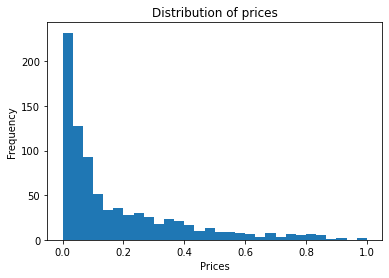

In [7]:
plt.hist(df.ave_price, bins=30, range=(0, 1))
plt.title('Distribution of prices')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

### Features

There are in total five different features: face_value, body_value, shirt_value, tier_value and hat_value, and they are all categorical variables. Since most of the features have many unique values (above 50), showing their relationship with price in a plot is difficult. We will use summary tables to show the average transaction price for each category. For the feature "tier_value", we will show the distribution of price for each category in a box plot. Lastly, since all the samples have "blue cat skin" as their body_value, we ignore the feature body_value in our EDA. 

First, for the feature "face_value", we can see the average transaction prices ranges from 0.08 (for "sunglass cowboy" category) to 0.93 (for "tvface 404" category). The average price for "tired" category is 2.5, which is likely caused by an outlier. 

In [8]:
df.groupby(by='face_value').mean().sort_values(by='ave_price')

,ave_price
face_value,
sunglasses cowboy,0.082845
tvface xp,0.085000
tvface bobross,0.094375
owo,0.101692
sunglasses heart,0.125325
glasses funny,0.137678
uwu,0.145815
sunglasses yellow,0.149023
double face,0.151860


For the feature "shirt_value", the average transaction prices ranges from 0.05 (for "monk" category) to 0.72 (for "robe king" category). The average price for "ninja black" category is 9.33, which is likely caused by an outlier.

In [9]:
df.groupby(by='shirt_value').mean().sort_values(by='ave_price')

,ave_price
shirt_value,
monk,0.052745
overalls yellow,0.052983
cowboy black,0.062329
pirate black,0.064692
knight leather,0.067500
...,...
astro orange,0.433159
astro black,0.441112
combat black,0.471111


For the feature "hats_value", the average transaction prices ranges from 0.01 (for "knight_blue" category) to 0.89 (for "knight black" category). The average price for "flower pink" category is 2.33, which is likely caused by an outlier.

In [10]:
df.groupby(by='hats_value').mean().sort_values(by='ave_price')

,ave_price
hats_value,
knight blue,0.014310
halo,0.022000
visor green,0.044736
deepsea bronze,0.049000
deepsea orange,0.064000
...,...
crown gold,0.548750
costume frog,0.550229
tvhead grey,0.557107


Lastly, below shows the boxplot of each category of the feature "tier_value". We notice that the category "exotic_2" clearly has a higher median than the other categories, and the categories "dassy_1", "dassy_2" and "exotic_2" are more dispersed in price than the other ones. 

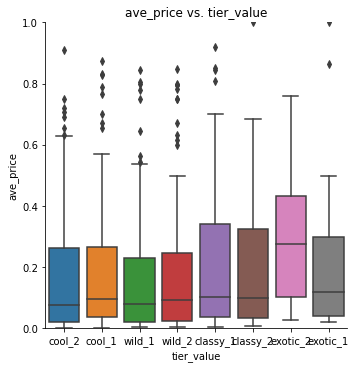

In [11]:
tier_value_plot = sns.catplot(x="tier_value", y="ave_price", kind="box",  data=df)
tier_value_plot.set(ylim=(0, 1))
plt.title('ave_price vs. tier_value')
plt.show()

### Feature Counts

Lastly, we examine if the count for each feature is related to average price, i.e., whether features having more counts are likely to be associated with higher price (possibly due to higher preference/demand for this feature) or lower price (due to less rareness). 

To begin with, we examine the relations between face_count (how many occurance of each face value in the collection) and the average price of each face value. The scatter plot below shows that most of the face values have more than 200 counts, but there is no clear pattern showing higher count would lead to either higher or lower average price. 

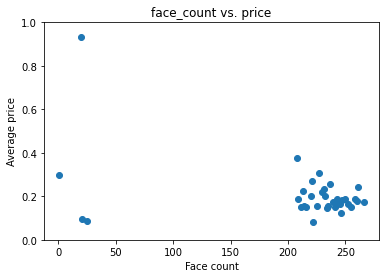

In [12]:
face_count = df.face_count.unique()
price = []
for current_face_count in face_count:
    current_price = df[df.face_count == current_face_count].ave_price.mean()
    price.append(current_price)
face_count = face_count.astype(int)

plt.scatter(x=face_count, y=price)
plt.ylim([0, 1])
plt.title('face_count vs. price')
plt.xlabel('Face count')
plt.ylabel('Average price')
plt.show()

For the relationship between shirt_count and price, it is also not clear if a higher shirt count is associated with a higher or lower average price. 

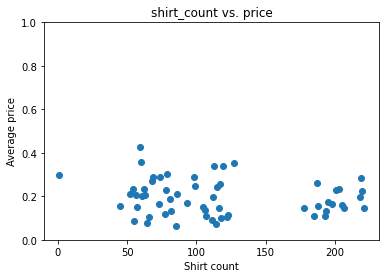

In [13]:
shirt_count = df.shirt_count.unique()
price = []
for current_shirt_count in shirt_count:
    current_price = df[df.shirt_count == current_shirt_count].ave_price.mean()
    price.append(current_price)
shirt_count = shirt_count.astype(int)

plt.scatter(x=shirt_count, y=price)
plt.ylim([0, 1])
plt.title('shirt_count vs. price')
plt.xlabel('Shirt count')
plt.ylabel('Average price')
plt.show()

For the relationship between tier_count and price, it is also not clear if a higher tier count is associated with a higher or lower average price.

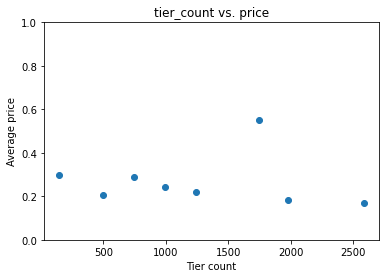

In [14]:
tier_count = df.tier_count.unique()
price = []
for current_tier_count in tier_count:
    current_price = df[df.tier_count == current_tier_count].ave_price.mean()
    price.append(current_price)
tier_count = tier_count.astype(int)

plt.scatter(x=tier_count, y=price)
plt.ylim([0, 1])
plt.title('tier_count vs. price')
plt.xlabel('Tier count')
plt.ylabel('Average price')
plt.show()

Lastly, for the relationship between hats_count and price, there is no clear pattern on whether a higher hats_count is associated with a higher or lower average price. 

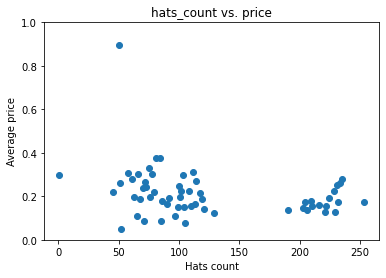

In [15]:
hats_count = df.hats_count.unique()
price = []
for current_hats_count in hats_count:
    current_price = df[df.hats_count == current_hats_count].ave_price.mean()
    price.append(current_price)
hats_count = hats_count.astype(int)

plt.scatter(x=hats_count, y=price)
plt.ylim([0, 1])
plt.title('hats_count vs. price')
plt.xlabel('Hats count')
plt.ylabel('Average price')
plt.show()

### Baseline Model

We implement a baseline linear regression based on the probability of the traits occurring in the NFT.

In [16]:
# Randomizing the rows in the dataset.
df = df.sample(frac=1)
df.head()

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count
138,9759,0.700000,beard tan,208,blue cat skin,9933,costume hotdog,63,classy_1,992,afro brown,112
312,9558,0.363583,sunglasses blue,245,blue cat skin,9933,sweater pink,116,cool_2,2584,mohawk green,233
80,9838,0.002700,sunglasses squad,213,blue cat skin,9933,buttondown black flannel,207,cool_2,2584,mohawk purple,221
714,9085,0.008500,mononoke,237,blue cat skin,9933,buttondown green,220,wild_2,1241,prince,84
355,9495,0.061290,sunglasses blue,245,blue cat skin,9933,robe red,198,cool_1,1979,beret green,222


In [17]:
# Computing the probabilities based on frequency counts.
num_items_in_collection = 9935
df['face_count_prob'] = df['face_count'].astype('int') / num_items_in_collection
df['body_count_prob'] = df['body_count'].astype('int') / num_items_in_collection
df['shirt_count_prob'] = df['shirt_count'].astype('int') / num_items_in_collection
df['tier_count_prob'] = df['tier_count'].astype('int') / num_items_in_collection
df['hats_count_prob'] = df['hats_count'].astype('int') / num_items_in_collection

df.head()

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob
138,9759,0.700000,beard tan,208,blue cat skin,9933,costume hotdog,63,classy_1,992,afro brown,112,0.020936,0.999799,0.006341,0.099849,0.011273
312,9558,0.363583,sunglasses blue,245,blue cat skin,9933,sweater pink,116,cool_2,2584,mohawk green,233,0.024660,0.999799,0.011676,0.260091,0.023452
80,9838,0.002700,sunglasses squad,213,blue cat skin,9933,buttondown black flannel,207,cool_2,2584,mohawk purple,221,0.021439,0.999799,0.020835,0.260091,0.022245
714,9085,0.008500,mononoke,237,blue cat skin,9933,buttondown green,220,wild_2,1241,prince,84,0.023855,0.999799,0.022144,0.124912,0.008455
355,9495,0.061290,sunglasses blue,245,blue cat skin,9933,robe red,198,cool_1,1979,beret green,222,0.024660,0.999799,0.019930,0.199195,0.022345


In [18]:
# Splitting data into 80% training and 20% test.
train, test = df.iloc[:int(len(df)*0.8),:], df.iloc[int(len(df)*0.8):,:]

In [19]:
# Creating X and Y sets.
features = ['face_count_prob', 'body_count_prob', 'shirt_count_prob', 'tier_count_prob', 'hats_count_prob' ]
target_variable = 'ave_price'

X_train = train[features]
Y_train = train[target_variable]

X_test = test[features]
Y_test = test[target_variable]

In [20]:
# Create linear regression model
linear_regression = linear_model.LinearRegression()

In [21]:
# Fit linear regression model.
linear_regression.fit(X_train, Y_train)

LinearRegression()

In [22]:
# Make predictions on the test set.
Y_test_predictions = linear_regression.predict(X_test)

In [23]:
# Results of linear regression.
print("Coefficients: \n", linear_regression.coef_)
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Coefficients: 
 [-2.30275810e+01 -9.76996262e-15 -2.53068442e+01  1.52177687e-01
  1.23749909e+01]
Mean squared error: 0.09
R2 score: -0.37


# Predicting the last sale.

In [24]:
last_sales_df = sale_events_df.sort_values(by='created_date', ascending=True).groupby('token_id').tail(1)

In [25]:
last_sales_df.head(10)

,token_id,collection,event_type,auction_type,bid_amount,ending_price,created_date,total_price,quantity
1644,9251,cool-cats-nft,successful,None,None,None,2021-07-01T23:17:45.410098,0.00110,1
1719,9212,cool-cats-nft,successful,None,None,None,2021-07-01T23:18:16.130480,0.00100,1
113,9866,cool-cats-nft,successful,None,None,None,2021-07-02T00:27:17.110235,0.00200,1
2153,9006,cool-cats-nft,successful,None,None,None,2021-07-02T01:11:58.291430,0.00270,1
2195,9002,cool-cats-nft,successful,None,None,None,2021-07-02T01:21:34.506466,0.00270,1
1567,9263,cool-cats-nft,successful,None,None,None,2021-07-02T02:20:57.317321,0.00200,1
1220,9409,cool-cats-nft,successful,None,None,None,2021-07-02T02:40:42.816273,0.00200,1
623,9639,cool-cats-nft,successful,None,None,None,2021-07-02T02:41:30.611609,0.00197,1
2249,9000,cool-cats-nft,successful,None,None,None,2021-07-02T02:49:37.223770,0.00400,1
1936,9126,cool-cats-nft,successful,None,None,None,2021-07-02T03:11:27.159422,0.00200,1


In [26]:
last_sales_df.loc[last_sales_df['token_id'] == 9932]

,token_id,collection,event_type,auction_type,bid_amount,ending_price,created_date,total_price,quantity
0,9932,cool-cats-nft,successful,None,None,None,2021-10-21T19:16:22.725846,0.655,1


In [27]:
last_sales_df = last_sales_df[['token_id', 'total_price']]

last_sales_df.columns = ['token_id', 'last_price']

last_sales_df.head(10)

,token_id,last_price
1644,9251,0.00110
1719,9212,0.00100
113,9866,0.00200
2153,9006,0.00270
2195,9002,0.00270
1567,9263,0.00200
1220,9409,0.00200
623,9639,0.00197
2249,9000,0.00400
1936,9126,0.00200


In [28]:
#df.head(10)
#left_df.merge(right_df, on='user_id', how='left')
#df = df.merge(last_sales_df, on='token_id', how='left')

#df.head(10)
df = df.astype({'token_id' : int})

df = df.merge(last_sales_df, on='token_id', how='left')

df.head(10)


,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob,last_price
0,9759,0.700000,beard tan,208,blue cat skin,9933,costume hotdog,63,classy_1,992,afro brown,112,0.020936,0.999799,0.006341,0.099849,0.011273,0.7000
1,9558,0.363583,sunglasses blue,245,blue cat skin,9933,sweater pink,116,cool_2,2584,mohawk green,233,0.024660,0.999799,0.011676,0.260091,0.023452,0.7750
2,9838,0.002700,sunglasses squad,213,blue cat skin,9933,buttondown black flannel,207,cool_2,2584,mohawk purple,221,0.021439,0.999799,0.020835,0.260091,0.022245,0.0027
3,9085,0.008500,mononoke,237,blue cat skin,9933,buttondown green,220,wild_2,1241,prince,84,0.023855,0.999799,0.022144,0.124912,0.008455,0.0085
4,9495,0.061290,sunglasses blue,245,blue cat skin,9933,robe red,198,cool_1,1979,beret green,222,0.024660,0.999799,0.019930,0.199195,0.022345,0.1480
5,9568,0.591000,ninja red,230,blue cat skin,9933,tanktop tattoo,123,cool_2,2584,headband red,216,0.023150,0.999799,0.012380,0.260091,0.021741,1.0490
6,9234,0.031250,mummy,261,blue cat skin,9933,viking navy,86,classy_2,747,knight blue,73,0.026271,0.999799,0.008656,0.075189,0.007348,0.0400
7,9051,0.827550,glasses,235,blue cat skin,9933,tshirt pink,203,cool_1,1979,bucket hat tan,231,0.023654,0.999799,0.020433,0.199195,0.023251,0.6200
8,9449,0.002300,sunglasses blue,245,blue cat skin,9933,buttondown black flannel,207,cool_1,1979,flower red,222,0.024660,0.999799,0.020835,0.199195,0.022345,0.0023
9,9705,0.156900,ninja red,230,blue cat skin,9933,tshirt white,99,wild_1,1743,helm army,104,0.023150,0.999799,0.009965,0.175440,0.010468,0.5000


In [29]:
# Adding log_last_price
df['log_last_price'] = np.log(1 + df['last_price'])

df.head(20)


,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob,last_price,log_last_price
0,9759,0.700000,beard tan,208,blue cat skin,9933,costume hotdog,63,classy_1,992,afro brown,112,0.020936,0.999799,0.006341,0.099849,0.011273,0.7000,0.530628
1,9558,0.363583,sunglasses blue,245,blue cat skin,9933,sweater pink,116,cool_2,2584,mohawk green,233,0.024660,0.999799,0.011676,0.260091,0.023452,0.7750,0.573800
2,9838,0.002700,sunglasses squad,213,blue cat skin,9933,buttondown black flannel,207,cool_2,2584,mohawk purple,221,0.021439,0.999799,0.020835,0.260091,0.022245,0.0027,0.002696
3,9085,0.008500,mononoke,237,blue cat skin,9933,buttondown green,220,wild_2,1241,prince,84,0.023855,0.999799,0.022144,0.124912,0.008455,0.0085,0.008464
4,9495,0.061290,sunglasses blue,245,blue cat skin,9933,robe red,198,cool_1,1979,beret green,222,0.024660,0.999799,0.019930,0.199195,0.022345,0.1480,0.138021
5,9568,0.591000,ninja red,230,blue cat skin,9933,tanktop tattoo,123,cool_2,2584,headband red,216,0.023150,0.999799,0.012380,0.260091,0.021741,1.0490,0.717352
6,9234,0.031250,mummy,261,blue cat skin,9933,viking navy,86,classy_2,747,knight blue,73,0.026271,0.999799,0.008656,0.075189,0.007348,0.0400,0.039221
7,9051,0.827550,glasses,235,blue cat skin,9933,tshirt pink,203,cool_1,1979,bucket hat tan,231,0.023654,0.999799,0.020433,0.199195,0.023251,0.6200,0.482426
8,9449,0.002300,sunglasses blue,245,blue cat skin,9933,buttondown black flannel,207,cool_1,1979,flower red,222,0.024660,0.999799,0.020835,0.199195,0.022345,0.0023,0.002297
9,9705,0.156900,ninja red,230,blue cat skin,9933,tshirt white,99,wild_1,1743,helm army,104,0.023150,0.999799,0.009965,0.175440,0.010468,0.5000,0.405465


In [30]:

# extracting all sales but the last.
#all_but_last_sales_df = sale_events_df.copy()
#all_but_last_sales_df.sort_values(by='created_date', ascending=True).groupby('token_id').pop(1)

#all_but_last_sales_df.head()

# Extracting num_sales
sales_count_df = sale_events_df.sort_values(by='created_date', ascending=True).groupby('token_id').count()

sales_count_df = sales_count_df.reset_index()

sales_count_df = sales_count_df[['token_id', 'quantity']]

sales_count_df.columns = ['token_id', 'num_sales']

df = df.merge(sales_count_df, on='token_id', how='left')

df.head(10)

,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,hats_value,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob,last_price,log_last_price,num_sales
0,9759,0.700000,beard tan,208,blue cat skin,9933,costume hotdog,63,classy_1,992,afro brown,112,0.020936,0.999799,0.006341,0.099849,0.011273,0.7000,0.530628,1
1,9558,0.363583,sunglasses blue,245,blue cat skin,9933,sweater pink,116,cool_2,2584,mohawk green,233,0.024660,0.999799,0.011676,0.260091,0.023452,0.7750,0.573800,6
2,9838,0.002700,sunglasses squad,213,blue cat skin,9933,buttondown black flannel,207,cool_2,2584,mohawk purple,221,0.021439,0.999799,0.020835,0.260091,0.022245,0.0027,0.002696,1
3,9085,0.008500,mononoke,237,blue cat skin,9933,buttondown green,220,wild_2,1241,prince,84,0.023855,0.999799,0.022144,0.124912,0.008455,0.0085,0.008464,1
4,9495,0.061290,sunglasses blue,245,blue cat skin,9933,robe red,198,cool_1,1979,beret green,222,0.024660,0.999799,0.019930,0.199195,0.022345,0.1480,0.138021,5
5,9568,0.591000,ninja red,230,blue cat skin,9933,tanktop tattoo,123,cool_2,2584,headband red,216,0.023150,0.999799,0.012380,0.260091,0.021741,1.0490,0.717352,4
6,9234,0.031250,mummy,261,blue cat skin,9933,viking navy,86,classy_2,747,knight blue,73,0.026271,0.999799,0.008656,0.075189,0.007348,0.0400,0.039221,2
7,9051,0.827550,glasses,235,blue cat skin,9933,tshirt pink,203,cool_1,1979,bucket hat tan,231,0.023654,0.999799,0.020433,0.199195,0.023251,0.6200,0.482426,2
8,9449,0.002300,sunglasses blue,245,blue cat skin,9933,buttondown black flannel,207,cool_1,1979,flower red,222,0.024660,0.999799,0.020835,0.199195,0.022345,0.0023,0.002297,1
9,9705,0.156900,ninja red,230,blue cat skin,9933,tshirt white,99,wild_1,1743,helm army,104,0.023150,0.999799,0.009965,0.175440,0.010468,0.5000,0.405465,5


In [31]:
# Adding historical_average_price
# Removing the weighted average of the last sale (which we're trying to predict.)
df['historical_ave_price'] = df['ave_price'] - df['last_price'] / df['num_sales']

df.head(20)



,token_id,ave_price,face_value,face_count,body_value,body_count,shirt_value,shirt_count,tier_value,tier_count,...,hats_count,face_count_prob,body_count_prob,shirt_count_prob,tier_count_prob,hats_count_prob,last_price,log_last_price,num_sales,historical_ave_price
0,9759,0.700000,beard tan,208,blue cat skin,9933,costume hotdog,63,classy_1,992,...,112,0.020936,0.999799,0.006341,0.099849,0.011273,0.7000,0.530628,1,0.000000
1,9558,0.363583,sunglasses blue,245,blue cat skin,9933,sweater pink,116,cool_2,2584,...,233,0.024660,0.999799,0.011676,0.260091,0.023452,0.7750,0.573800,6,0.234417
2,9838,0.002700,sunglasses squad,213,blue cat skin,9933,buttondown black flannel,207,cool_2,2584,...,221,0.021439,0.999799,0.020835,0.260091,0.022245,0.0027,0.002696,1,0.000000
3,9085,0.008500,mononoke,237,blue cat skin,9933,buttondown green,220,wild_2,1241,...,84,0.023855,0.999799,0.022144,0.124912,0.008455,0.0085,0.008464,1,0.000000
4,9495,0.061290,sunglasses blue,245,blue cat skin,9933,robe red,198,cool_1,1979,...,222,0.024660,0.999799,0.019930,0.199195,0.022345,0.1480,0.138021,5,0.031690
5,9568,0.591000,ninja red,230,blue cat skin,9933,tanktop tattoo,123,cool_2,2584,...,216,0.023150,0.999799,0.012380,0.260091,0.021741,1.0490,0.717352,4,0.328750
6,9234,0.031250,mummy,261,blue cat skin,9933,viking navy,86,classy_2,747,...,73,0.026271,0.999799,0.008656,0.075189,0.007348,0.0400,0.039221,2,0.011250
7,9051,0.827550,glasses,235,blue cat skin,9933,tshirt pink,203,cool_1,1979,...,231,0.023654,0.999799,0.020433,0.199195,0.023251,0.6200,0.482426,2,0.517550
8,9449,0.002300,sunglasses blue,245,blue cat skin,9933,buttondown black flannel,207,cool_1,1979,...,222,0.024660,0.999799,0.020835,0.199195,0.022345,0.0023,0.002297,1,0.000000
9,9705,0.156900,ninja red,230,blue cat skin,9933,tshirt white,99,wild_1,1743,...,104,0.023150,0.999799,0.009965,0.175440,0.010468,0.5000,0.405465,5,0.056900


In [32]:
# Setting categorical columns.
categorical_columns = ['face_value', 'body_value', 'shirt_value', 'tier_value', 'hats_value']
for categorical_column in categorical_columns:
    if categorical_column not in df.columns:
        df = pd.concat([df,pd.get_dummies(df[categorical_column], prefix=categorical_column)],axis=1)
        


In [33]:
# NOTE: Restricting to examples with non-empty historical sales.
pos_df = df[df.num_sales > 1]

In [34]:
# Splitting data into 80% training and 20% test.
train, test = pos_df.iloc[:int(len(df)*0.8),:], df.iloc[int(len(df)*0.8):,:]

In [35]:
# Creating X and Y sets.
#features = ['face_count_prob', 'body_count_prob', 'shirt_count_prob', 'tier_count_prob', 'hats_count_prob', 'num_sales',
#           'face_value', 'body_value', 'shirt_value', 'tier_value', 'hats_value']
features = [x for x in df.columns if x != 'last_price' and x != 'ave_price' and x != 'face_value' and x != 'body_value'
           and x != 'shirt_value' and x != 'hats_value' and x != 'tier_value' and x != 'log_last_price']

#print(df['classy_1'])

target_variable = 'last_price'

X_train = train[features]
Y_train = train[target_variable]

for feature in features:
    print(feature)

X_test = test[features]
Y_test = test[target_variable]

token_id
face_count
body_count
shirt_count
tier_count
hats_count
face_count_prob
body_count_prob
shirt_count_prob
tier_count_prob
hats_count_prob
num_sales
historical_ave_price


In [36]:
# Create linear regression model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
#linear_regression = linear_model.LinearRegression()
linear_regression = make_pipeline(StandardScaler(),
                     linear_model.LinearRegression())

In [37]:
# Fit linear regression model.
linear_regression.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [38]:
# Make predictions on the test set.
Y_test_predictions = linear_regression.predict(X_test)

In [39]:
# Results of linear regression.
#print("Coefficients: \n", linear_regression.coef_)
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.12
R2 score: 0.13


In [40]:
Y_test_predictions[:10]

array([0.32071437, 0.53878531, 0.19741183, 0.38608003, 0.25475186,
       0.15189268, 0.26426617, 0.3542238 , 0.60301486, 0.65710055])

In [41]:
Y_test[:10]

679    0.088000
680    0.595000
681    0.063000
682    0.220000
683    0.077700
684    0.080000
685    0.129000
686    0.720000
687    0.340000
688    0.719024
Name: last_price, dtype: float64

In [42]:
# Applying KNN
from sklearn.neighbors import KNeighborsRegressor
knnRegressor = make_pipeline(StandardScaler(),
                     KNeighborsRegressor(n_neighbors=100))

knnRegressor.fit(X_train, Y_train)
Y_test_predictions = knnRegressor.predict(X_test)

In [43]:
# Results of KNN.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.13
R2 score: 0.06


In [44]:
Y_test_predictions[:10]

array([0.40354775, 0.4820903 , 0.3128975 , 0.42425035, 0.3006358 ,
       0.34222905, 0.3642794 , 0.41417105, 0.4699611 , 0.45620214])

In [45]:
# Kernel Ridge
from sklearn.kernel_ridge import KernelRidge
krr = make_pipeline(StandardScaler(),
                    KernelRidge())
krr.fit(X_train, Y_train)
Y_test_predictions = krr.predict(X_test)

In [46]:
# Results of KNN.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.27
R2 score: -0.93


In [47]:
Y_test_predictions[:10]

array([-0.12416883,  0.0935402 , -0.24727621, -0.05889507, -0.19007567,
       -0.29277236, -0.18058215, -0.0907573 ,  0.15769352,  0.21160997])

In [48]:
# Ridge CV
from sklearn.linear_model import RidgeCV

ridgeCV = make_pipeline(StandardScaler(),
                    RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, Y_train))
ridgeCV.fit(X_train, Y_train)
Y_test_predictions = ridgeCV.predict(X_test)

In [49]:
# Results of KNN.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.12
R2 score: 0.13


In [50]:
Y_test_predictions[:10]

array([0.32091683, 0.53862585, 0.19780944, 0.38619058, 0.25500998,
       0.1523133 , 0.26450351, 0.35432835, 0.60277918, 0.65669562])

In [51]:
# SGD Regressor.
from sklearn.linear_model import SGDRegressor
#sgdRegressor = SGDRegressor(max_iter=1000, tol=1e-3)
reg = make_pipeline(StandardScaler(),
                     SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, Y_train)
Y_test_predictions = reg.predict(X_test)

In [52]:
# Results of KNN.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.12
R2 score: 0.11


In [53]:
Y_test_predictions[:10]

array([0.29685451, 0.52119466, 0.17005525, 0.36942949, 0.23600361,
       0.11048966, 0.23938693, 0.32230542, 0.59015216, 0.66199911])

In [54]:
# Bayesian ARD
from sklearn import linear_model

ard = make_pipeline(StandardScaler(),
                    linear_model.ARDRegression())
ard.fit(X_train, Y_train)
Y_test_predictions = ard.predict(X_test)

In [55]:
# Results of ARD.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.12
R2 score: 0.12


In [56]:
# Bayesian Ridge

bayesRidge = make_pipeline(StandardScaler(),
                    linear_model.BayesianRidge())
bayesRidge.fit(X_train, Y_train)
Y_test_predictions = bayesRidge.predict(X_test)

In [57]:
# Results of Bayesian Ridge.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.12
R2 score: 0.12


In [58]:
# MLP Regressor
from sklearn.neural_network import MLPRegressor

mlpRegressor = make_pipeline(StandardScaler(),
                    MLPRegressor(random_state=1, max_iter=500))
mlpRegressor.fit(X_train, Y_train)
Y_test_predictions = mlpRegressor.predict(X_test)

In [59]:
# Results of MLP Regressor.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.12
R2 score: 0.17


In [60]:
# Linear SVR
from sklearn.svm import LinearSVR

linearSVR = make_pipeline(StandardScaler(),
                    LinearSVR(random_state=0, tol=1e-5, max_iter = 3000))
linearSVR.fit(X_train, Y_train)
Y_test_predictions = linearSVR.predict(X_test)

C:\Users\oswal\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [61]:
# Results of Linear SVR.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.14
R2 score: -0.01


In [62]:
# Nu SVR
from sklearn.svm import NuSVR

nuSVR = make_pipeline(StandardScaler(),
                    NuSVR(C=1.0, nu=0.1))
nuSVR.fit(X_train, Y_train)
Y_test_predictions = nuSVR.predict(X_test)

In [63]:
# Results of Nu SVR.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.19
R2 score: -0.36


In [64]:
# SVR
from sklearn.svm import SVR

svr = make_pipeline(StandardScaler(),
                    SVR(C=1.0, epsilon=0.2))
svr.fit(X_train, Y_train)
Y_test_predictions = svr.predict(X_test)

In [65]:
# Results of SVR.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.09
R2 score: 0.34


In [66]:
# Decision Tree Regressor
from sklearn.tree import DecisionTreeRegressor

decisionTreeRegressor = make_pipeline(StandardScaler(),
                    DecisionTreeRegressor(random_state=0))
decisionTreeRegressor.fit(X_train, Y_train)
Y_test_predictions = decisionTreeRegressor.predict(X_test)

In [67]:
# Results of Decision Tree Regressor.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.14
R2 score: -0.01


In [68]:
# Extra Tree Regressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor

extra_tree = ExtraTreeRegressor(random_state=0)
baggingRegressor = BaggingRegressor(extra_tree, random_state=0).fit(X_train, Y_train)

Y_test_predictions = baggingRegressor.predict(X_test)

In [69]:
# Results of Extra Tree Regressor.
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_test_predictions))
print("R2 score: %.2f" % r2_score(Y_test, Y_test_predictions))

Mean squared error: 0.06
R2 score: 0.60
